In [1]:
import torch
import csv
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# os.chdir(r"C:\Users\jpresman\cernbox\Documents\Projects\ML_Pipeline")
os.chdir(r"D:\Projects\ML_Pipeline")

%matplotlib inline

## Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/new-york-housing-market")

print(f"Dataset downloaded at {path}"   )


Dataset downloaded at C:\Users\Presmanes\.cache\kagglehub\datasets\nelgiriyewithana\new-york-housing-market\versions\1


# Frame the problem!

The objective of this project is to predict the price of real estate properties based on various features such as the number of bedrooms, bathrooms, square footage, location, among others.

Additionally, we will build a pipeline using scikit-learn to automate the process of data preprocessing, feature selection, model training, and evaluation.

We will also create derived features that can improve the model's performance, such as the relationship between the number of bedrooms and bathrooms, or the density of bedrooms per square foot.

# Explore data

In [3]:
df = pd.read_csv(r"./data/raw/NY-House-Dataset.csv")

df.head()

BROKERTITLE                TYPE  \
0        Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                Brokered by Serhant      Condo for sale   
2                             Brokered by Sowae Corp      House for sale   
3                                Brokered by COMPASS      Condo for sale   
4  Brokered by Sotheby's International Realty - E...  Townhouse for sale   

       PRICE  BEDS       BATH  PROPERTYSQFT  \
0     315000     2   2.000000        1400.0   
1  195000000     7  10.000000       17545.0   
2     260000     4   2.000000        2015.0   
3      69000     3   1.000000         445.0   
4   55000000     7   2.373861       14175.0   

                                             ADDRESS                    STATE  \
0                               2 E 55th St Unit 803       New York, NY 10022   
1  Central Park Tower Penthouse-217 W 57th New Yo...       New York, NY 10019   
2                                   620 Sinclair Ave  Staten Island, NY 10312   
3                            2 E 55th St Unit 908W33      Manhattan, NY 10022   
4                                        5 E 64th St       New York, NY 10065   

                                        MAIN_ADDRESS  \
0             2 E 55th St Unit 803New York, NY 10022   
1  Central Park Tower Penthouse-217 W 57th New Yo...   
2            620 Sinclair AveStaten Island, NY 10312   
3         2 E 55th St Unit 908W33Manhattan, NY 10022   
4                      5 E 64th StNew York, NY 10065   

  ADMINISTRATIVE_AREA_LEVEL_2  LOCALITY      SUBLOCALITY       STREET_NAME  \
0             New York County  New York        Manhattan  East 55th Street   
1               United States  New York  New York County          New York   
2               United States  New York  Richmond County     Staten Island   
3               United States  New York  New York County          New York   
4               United States  New York  New York County          New York   

          LONG_NAME                                  FORMATTED_ADDRESS  \
0   Regis Residence  Regis Residence, 2 E 55th St #803, New York, N...   
1  West 57th Street             217 W 57th St, New York, NY 10019, USA   
2   Sinclair Avenue     620 Sinclair Ave, Staten Island, NY 10312, USA   
3  East 55th Street               2 E 55th St, New York, NY 10022, USA   
4  East 64th Street               5 E 64th St, New York, NY 10065, USA   

    LATITUDE  LONGITUDE  
0  40.761255 -73.974483  
1  40.766393 -73.980991  
2  40.541805 -74.196109  
3  40.761398 -73.974613  
4  40.767224 -73.969856

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [5]:
df.describe()

PRICE         BEDS         BATH  PROPERTYSQFT     LATITUDE  \
count  4.801000e+03  4801.000000  4801.000000   4801.000000  4801.000000   
mean   2.356940e+06     3.356801     2.373861   2184.207862    40.714227   
std    3.135525e+07     2.602315     1.946962   2377.140894     0.087676   
min    2.494000e+03     1.000000     0.000000    230.000000    40.499546   
25%    4.990000e+05     2.000000     1.000000   1200.000000    40.639375   
50%    8.250000e+05     3.000000     2.000000   2184.207862    40.726749   
75%    1.495000e+06     4.000000     3.000000   2184.207862    40.771923   
max    2.147484e+09    50.000000    50.000000  65535.000000    40.912729   

         LONGITUDE  
count  4801.000000  
mean    -73.941601  
std       0.101082  
min     -74.253033  
25%     -73.987143  
50%     -73.949189  
75%     -73.870638  
max     -73.702450

We have a dataset of 4800 values; it is not a very large dataset, but it is sufficient for an initial analysis.

In [6]:
dropping_cols = ["BROKERTITLE", "TYPE", "MAIN_ADDRESS", "LONG_NAME", "FORMATTED_ADDRESS"]

df.drop(columns=dropping_cols, inplace=True)

## Raw Feature

### Location - Price

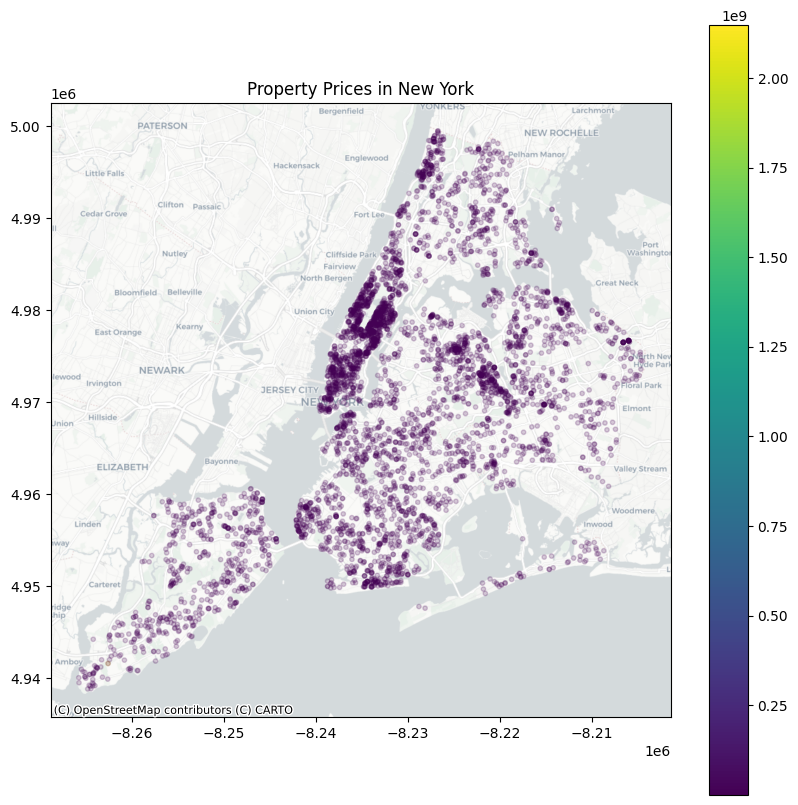

In [7]:
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(
    figsize     = (10, 10),
    column      = "PRICE", 
    cmap        = "viridis",        
    markersize  = 10,
    alpha       = 0.2,
    legend      = True,
    k           = 10
            
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Property Prices in New York")
plt.show()


### Distribution of numerical features

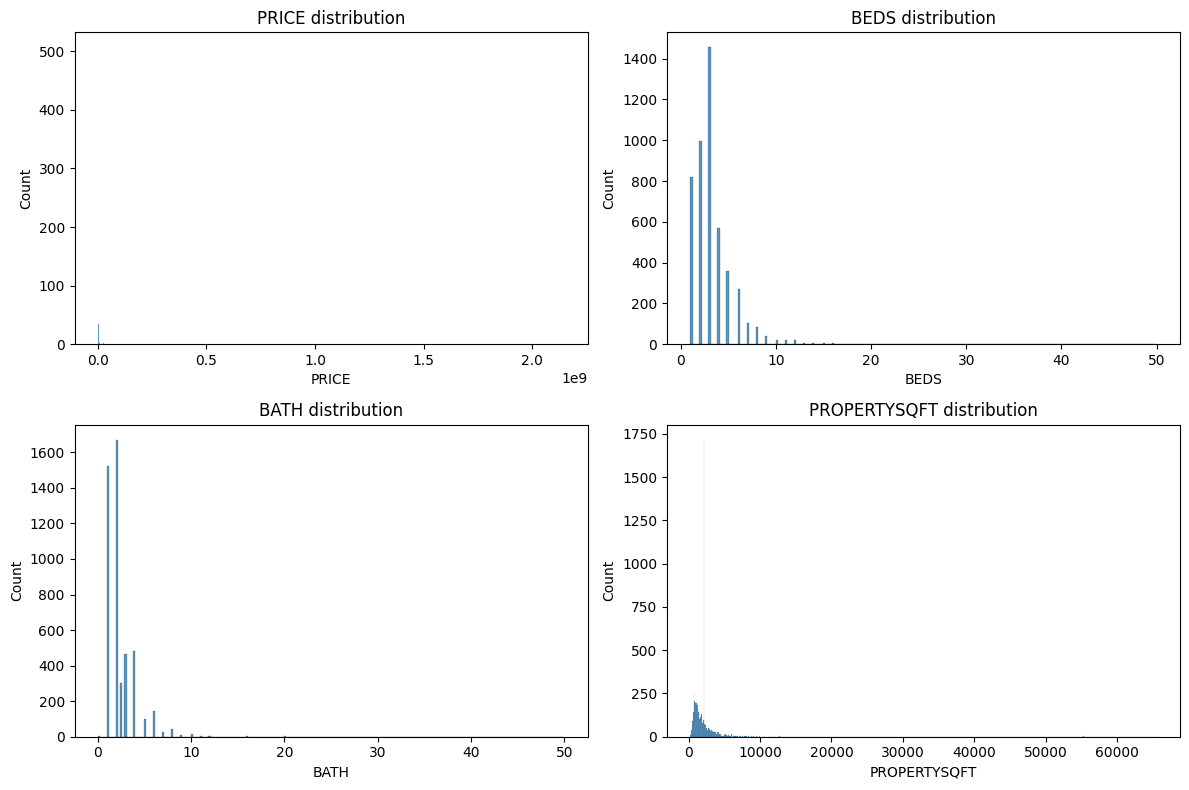

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['PRICE'], ax=axes[0, 0], kde=False)
axes[0, 0].set_title('PRICE distribution')

sns.histplot(df['BEDS'], ax=axes[0, 1], kde=False)
axes[0, 1].set_title('BEDS distribution')

sns.histplot(df['BATH'], ax=axes[1, 0], kde=False)
axes[1, 0].set_title('BATH distribution')

sns.histplot(df['PROPERTYSQFT'], ax=axes[1, 1], kde=False)
axes[1, 1].set_title('PROPERTYSQFT distribution')

plt.tight_layout()
plt.show()

We observe right-skewed distributions, indicating that most properties have lower prices, bedrooms, bathrooms, and square footage, with some properties having much higher values.

We will treat these values as outliers below.

### Outliers in numerical features

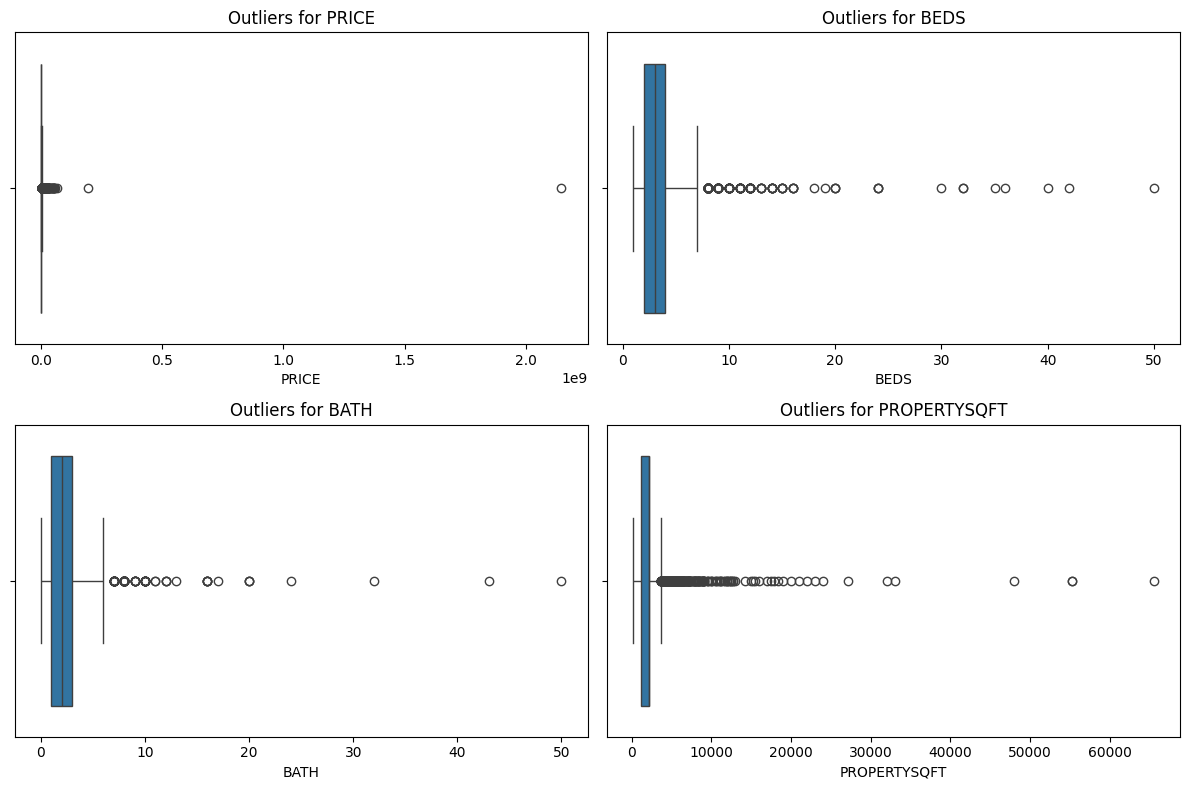

In [9]:
features = ['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    sns.boxplot(x=df[feature], ax=axes[row, col])
    axes[row, col].set_title(f'Outliers for {feature}')

plt.tight_layout()
plt.show()

In [10]:
# Print median and IQR for each numerical feature
for feature in features:
    median = df[feature].median()
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    # Print median and limits 
    print(f""""Feature {feature}:
            Median: {median}
            Q1: {q1}
            Q3: {q3}
            IQR: {iqr}
            Lower limit: {q1 - 1.5 * iqr}
            Upper limit: {q3 + 1.5 * iqr}
          """)

"Feature PRICE:
            Median: 825000.0
            Q1: 499000.0
            Q3: 1495000.0
            IQR: 996000.0
            Lower limit: -995000.0
            Upper limit: 2989000.0
          
"Feature BEDS:
            Median: 3.0
            Q1: 2.0
            Q3: 4.0
            IQR: 2.0
            Lower limit: -1.0
            Upper limit: 7.0
          
"Feature BATH:
            Median: 2.0
            Q1: 1.0
            Q3: 3.0
            IQR: 2.0
            Lower limit: -2.0
            Upper limit: 6.0
          
"Feature PROPERTYSQFT:
            Median: 2184.207862
            Q1: 1200.0
            Q3: 2184.207862
            IQR: 984.2078620000002
            Lower limit: -276.3117930000003
            Upper limit: 3660.5196550000005
          


We can find some outliers in the numertical features, for example, some houses with + 50 BEDS or BATHS.

### Correlation Matrix

In [11]:
num_vars = ["PRICE", "BEDS", "BATH", "PROPERTYSQFT"]
corr_matrix = df[num_vars].corr(method="pearson")
print(corr_matrix)

                 PRICE      BEDS      BATH  PROPERTYSQFT
PRICE         1.000000  0.052189  0.079371      0.110889
BEDS          0.052189  1.000000  0.776447      0.420503
BATH          0.079371  0.776447  1.000000      0.483935
PROPERTYSQFT  0.110889  0.420503  0.483935      1.000000


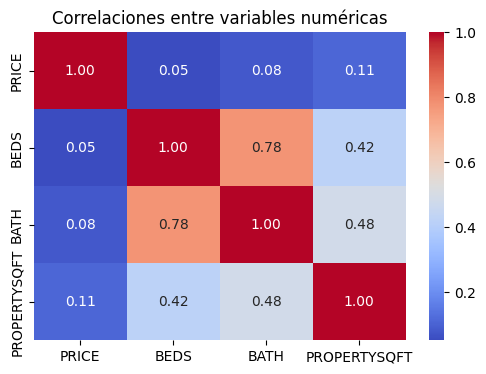

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlaciones entre variables numéricas")
plt.show()

With this, we can see that in the raw data, there is a low correlation between price and the rest of the numerical features. 

We only found a moderate correlation between PROPERTYSQFT and BEDS and in between BEDS and BATH.

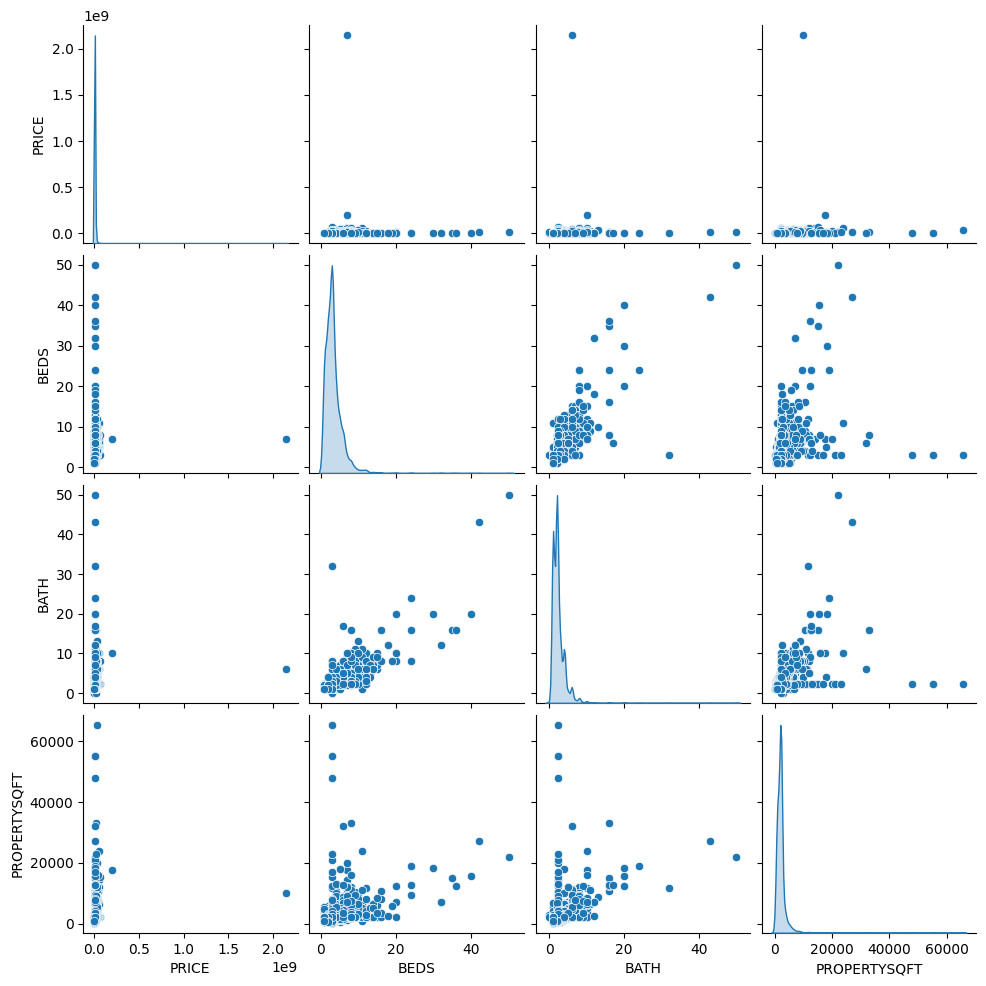

In [13]:
sns.pairplot(df[num_vars], diag_kind="kde")
plt.show()

# Create test set

Para evitar sesgarnos a la hora de evaluar metricas y hacer limpiezas, vamos a crear un test set desde el principio. El cual solo usaremos al final del proyecto para evaluar el modelo final.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

bins    = df["PRICE"].quantile([0.2, 0.4, 0.6, 0.8, 1]).values
labels  = [1, 2, 3, 4, 5]

df["PRICE_CAT"] = pd.cut(
    df["PRICE"],
    bins=np.quantile(df["PRICE"], [0, 0.2, 0.4, 0.6, 0.8, 1.0]),
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
)

# 2. Configurar StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

strat_split = []



for train_idx, test_idx in split.split(df, df["PRICE_CAT"]):
    strat_train_set = df.iloc[train_idx]
    strat_test_set  = df.iloc[test_idx]
    
    strat_split.append((strat_train_set, strat_test_set))


In [15]:
strat_train_set, strat_test_set = strat_split[0]

strat_train_set

PRICE  BEDS  BATH  PROPERTYSQFT                       ADDRESS  \
1400   129000     3   1.0   2184.207862        87-15 165th St Unit 2A   
2974  6000000     4   4.0   2184.207862  480 Park Avenue Ave Unit 18H   
3074   709999     4   2.0   2184.207862               116-40 148th St   
3463  4000000     6   4.0   5854.000000                     62 3rd St   
2638  2399000     5   5.0   2184.207862              208 Mayfair Dr N   
...       ...   ...   ...           ...                           ...   
2278   649000     3   3.0   1456.000000                 58 Roanoke St   
2801   995000     1   1.0   2184.207862           111 N 9th St Apt 2L   
3015  1960000     8   7.0   2184.207862                71-60 163rd St   
4243  2649000     3   3.0   1500.000000        325 Fifth Ave Unit 36A   
325   2350000     1   2.0   1144.000000    456 W 19th St Units 4 & 5C   

                        STATE ADMINISTRATIVE_AREA_LEVEL_2         LOCALITY  \
1400        Jamaica, NY 11432                    New York    Queens County   
2974      Manhattan, NY 10022                    New York  New York County   
3074        Jamaica, NY 11436               United States         New York   
3463       Brooklyn, NY 11231               United States         New York   
2638       Brooklyn, NY 11234               United States         New York   
...                       ...                         ...              ...   
2278  Staten Island, NY 10314               United States         New York   
2801       Brooklyn, NY 11249                    New York     Kings County   
3015  Fresh Meadows, NY 11365               United States         New York   
4243      Manhattan, NY 10016                    New York  New York County   
325       Manhattan, NY 10011               United States         New York   

          SUBLOCALITY    STREET_NAME   LATITUDE  LONGITUDE PRICE_CAT  
1400           Queens        Jamaica  40.710451 -73.798206         1  
2974         New York      Manhattan  40.762555 -73.970384         5  
3074    Queens County         Queens  40.681188 -73.793438         3  
3463     Kings County       Brooklyn  40.677739 -73.993949         5  
2638     Kings County       Brooklyn  40.611552 -73.906198         5  
...               ...            ...        ...        ...       ...  
2278  Richmond County  Staten Island  40.597298 -74.134727         2  
2801         Brooklyn   Williamsburg  40.720115 -73.958126         3  
3015    Queens County         Queens  40.728684 -73.806582         5  
4243         New York      Manhattan  40.747335 -73.984862         5  
325   New York County       New York  40.744926 -74.005718         5  

[4320 rows x 13 columns]

# Clean Up

#### Filter Price and PropertySqft outliers

Transform prices to log scale since the distribution is right-skewed.

In [16]:
df["PRICE_LOG"] = np.log1p(df["PRICE"])
df["SQFT_LOG"] = np.log1p(df["PROPERTYSQFT"])

original_df = df.copy()

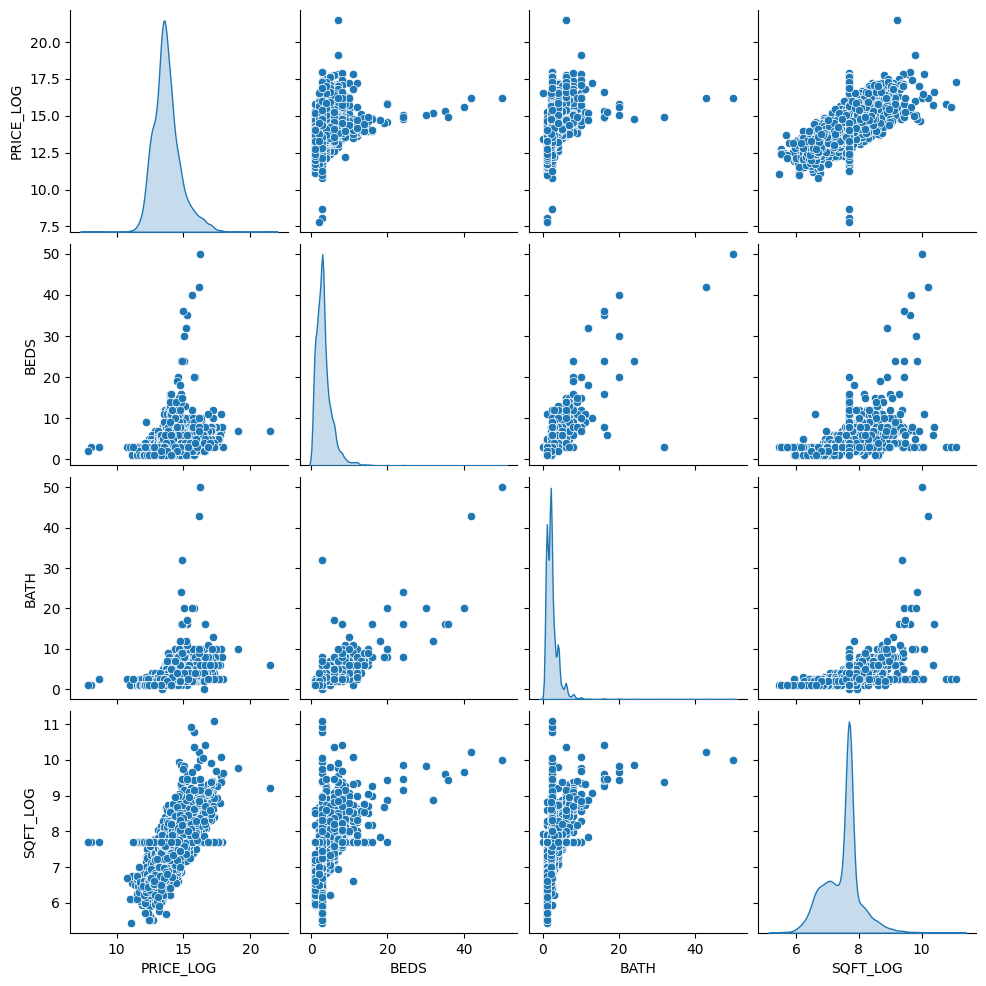

In [230]:
# Pairplot after transformation
sns.pairplot(df[["PRICE_LOG", "BEDS", "BATH", "SQFT_LOG"]], diag_kind="kde")
plt.show()

##### Price

In [17]:
n_total = len(df)

price_log_q1 = original_df["PRICE_LOG"].quantile(0.25)
price_log_q3 = original_df["PRICE_LOG"].quantile(0.75)
price_log_iqr = price_log_q3 - price_log_q1

upper_limit_price_log = price_log_q3 + 1.5 * price_log_iqr
lower_limit_price_log = price_log_q1 - 1.5 * price_log_iqr

df = df[
    (df["PRICE_LOG"] <= upper_limit_price_log) &
    (df["PRICE_LOG"] >= lower_limit_price_log)
    ]

n_after = len(df)

removed = n_total - n_after
print(f"Removed {n_total - n_after} outliers based on PRICE ({removed / n_total:.2%} of total)")
print(f"Removed houses with PRICE_LOG above {upper_limit_price_log:.2f} -> PRICE above {np.expm1(upper_limit_price_log):.2f}")

Removed 218 outliers based on PRICE (4.54% of total)
Removed houses with PRICE_LOG above 15.86 -> PRICE above 7752674.10


##### SQFT

In [18]:
sqft_log_q1 = original_df["SQFT_LOG"].quantile(0.25)
sqft_log_q3 = original_df["SQFT_LOG"].quantile(0.75)

sqft_log_iqr = sqft_log_q3 - sqft_log_q1

upper_limit_sqft_log = sqft_log_q3 + 1.5 * sqft_log_iqr
lower_limit_price_log = sqft_log_q1 - 1.5 * sqft_log_iqr

df = df[
    (df["SQFT_LOG"] <= upper_limit_sqft_log) &
    (df["SQFT_LOG"] >= lower_limit_price_log)
    ]

n_after = len(df)

removed = n_total - n_after
print(f"Removed {n_total - n_after} outliers based on SQFT ({removed / n_total:.2%} of total)")
print(f"Removed houses with SQFT_LOG above {upper_limit_sqft_log:.2f} -> SQFT above {np.expm1(upper_limit_sqft_log):.2f}")

Removed 355 outliers based on SQFT (7.39% of total)
Removed houses with SQFT_LOG above 8.59 -> SQFT above 5362.12


#### Filter BEDS and BATHS outliers

##### BEDS

In [19]:
# before_filtering
n_total = len(df)

beds_q1 = original_df["BEDS"].quantile(0.25)
beds_q3 = original_df["BEDS"].quantile(0.75)
beds_iqr = beds_q3 - beds_q1

upper_limit_beds = beds_q3 + 1.5 * beds_iqr
lower_limit_beds = 1

df = df[
    (df["BEDS"] <= upper_limit_beds) &
    (df["BEDS"] >= lower_limit_beds)
    ]

n_after = len(df)

removed = n_total - n_after

print(f"Removed {n_total - n_after} outliers based on BEDS ({removed / n_total:.2%} of total)")
print(f"Removed houses with BEDS above {upper_limit_beds} beds")

Removed 156 outliers based on BEDS (3.51% of total)
Removed houses with BEDS above 7.0 beds


##### BATHS

In [20]:
# before_filtering
n_total = len(df)

beds_q1 = original_df["BATH"].quantile(0.25)
beds_q3 = original_df["BATH"].quantile(0.75)
beds_iqr = beds_q3 - beds_q1

upper_limit_beds = beds_q3 + 1.5 * beds_iqr
lower_limit_beds = 1

df = df[
    (df["BATH"] <= upper_limit_beds) &
    (df["BATH"] >= lower_limit_beds)
    ]

n_after = len(df)

removed = n_total - n_after

print(f"Removed {n_total - n_after} outliers based on BATHS ({removed / n_total:.2%} of total)")
print(f"Removed houses with BATHS above {upper_limit_beds} beds")

Removed 11 outliers based on BATHS (0.26% of total)
Removed houses with BATHS above 6.0 beds


In [21]:
# Total rows removed
total_removed = len(original_df) - len(df)
print(f"Total rows removed: {total_removed} ({total_removed / len(original_df):.2%} of total)")

Total rows removed: 522 (10.87% of total)


After removing outliers in PRICE, PROPERTYSQFT, BEDS, and BATHS, we have eliminated a total of 522 rows, which represents 10.88% of the total data.

It is important to note that we removed outliers both above and below the range, as in the case of BEDS and BATHS, it makes sense to exclude properties with 0 or 1 bedroom or bathroom.

### Distribution of numerical features

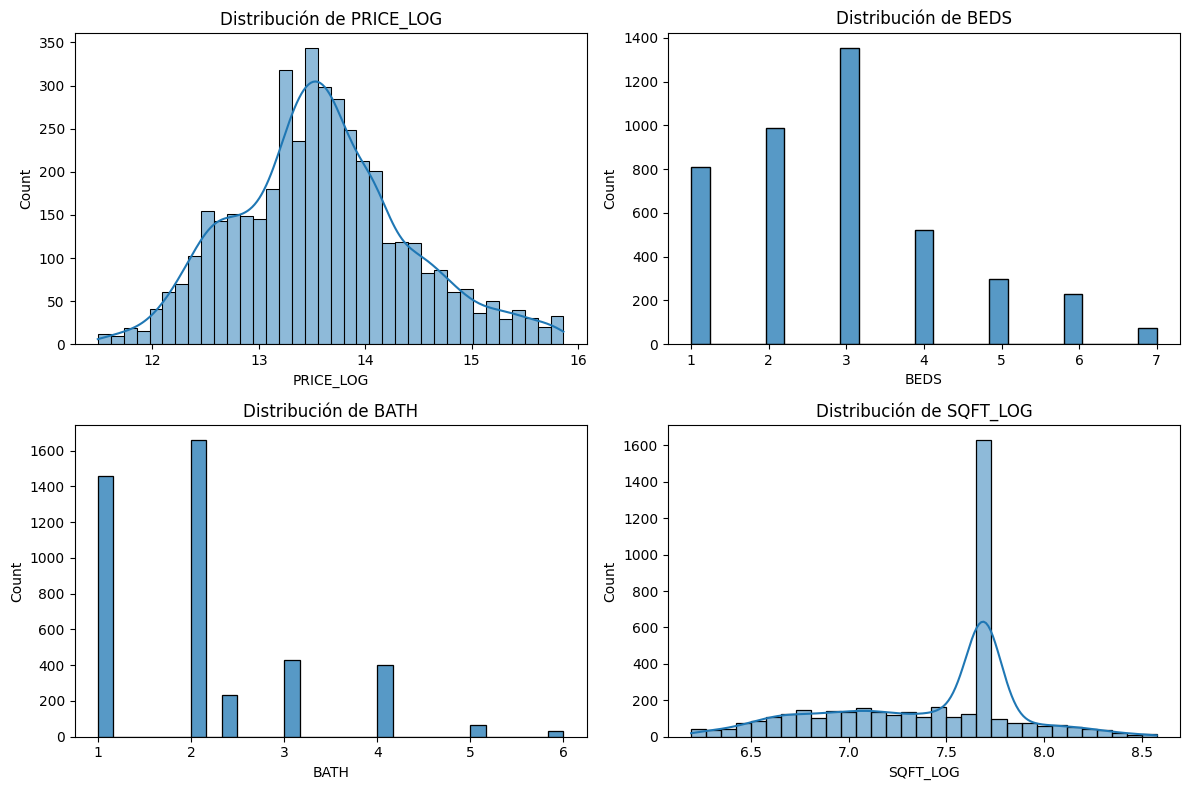

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['PRICE_LOG'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribución de PRICE_LOG')

sns.histplot(df['BEDS'], ax=axes[0, 1], kde=False)
axes[0, 1].set_title('Distribución de BEDS')

sns.histplot(df['BATH'], ax=axes[1, 0], kde=False)
axes[1, 0].set_title('Distribución de BATH')

sns.histplot(df['SQFT_LOG'], ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribución de SQFT_LOG')

plt.tight_layout()
plt.show()

### Correlation Matrix

In [23]:
num_vars = ["PRICE_LOG", "BEDS", "BATH", "SQFT_LOG"]
corr_matrix = df[num_vars].corr(method="pearson")  # Pearson es lo más común
print(corr_matrix)

           PRICE_LOG      BEDS      BATH  SQFT_LOG
PRICE_LOG   1.000000  0.439307  0.609580  0.458375
BEDS        0.439307  1.000000  0.678831  0.499786
BATH        0.609580  0.678831  1.000000  0.494482
SQFT_LOG    0.458375  0.499786  0.494482  1.000000


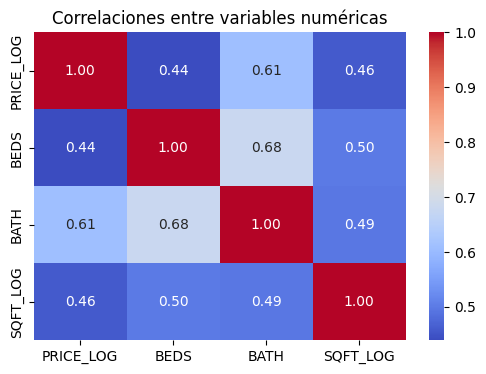

In [24]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlaciones entre variables numéricas")
plt.show()

After cleaning up the data, we can see some interesting correlations:

1. PRICE_LOG has a moderate correlation with SQFT_LOG and BEDS while it is more correlated to BATH number.
2. BATH and BEDS have the highest correlation
3. BATH and BEDS are correlated to SQFT_LOG with a moderate level


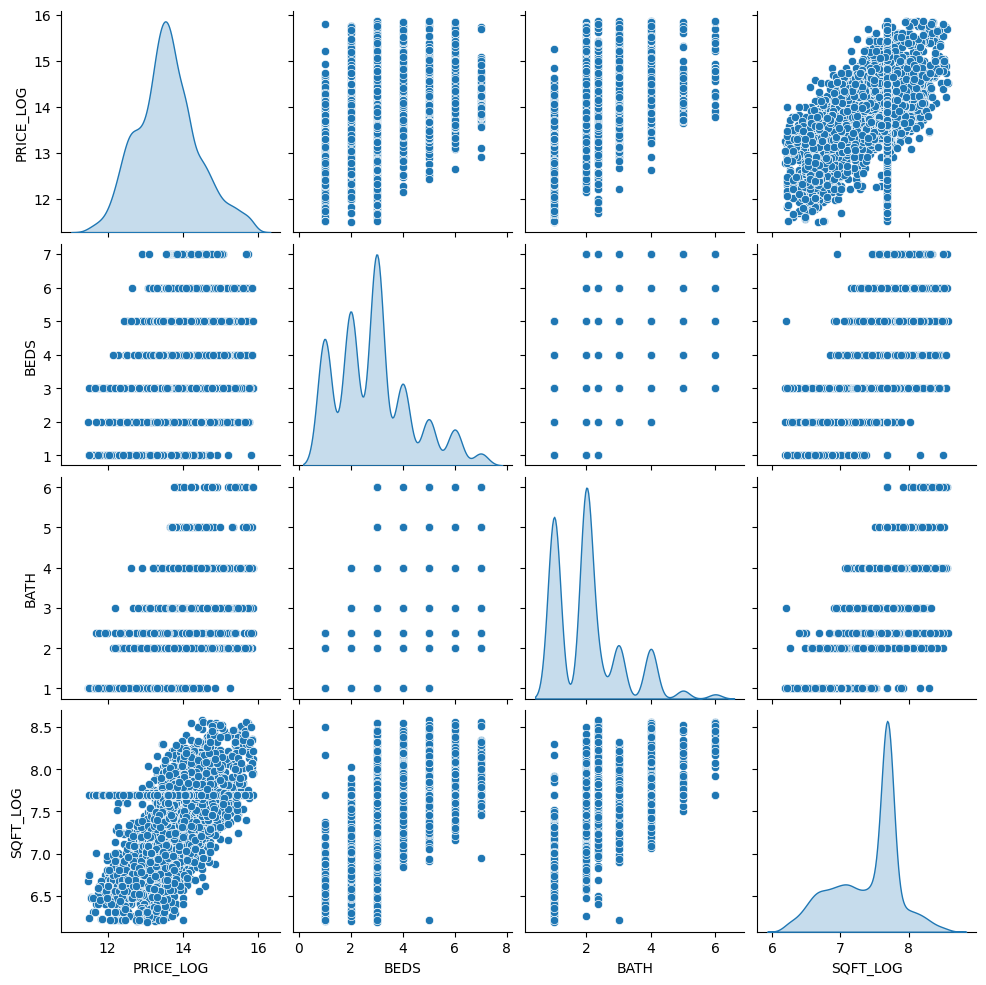

In [25]:
sns.pairplot(df[num_vars], diag_kind="kde")
plt.show()

When representing the data again, we can clearly see that there is significant dispersion in the data, for example, in BEDS and BATH as a function of price.

Additionally, when comparing SQFT_LOG with PRICE_LOG, we can observe a peak of data around 7.8 SQFT_LOG, which corresponds to ~2400 SQFT, a very common value for houses.

# Fature Engineering

## Extraction

In [26]:
def feature_summary(series: pd.Series, name: str = None):
    q1 = series.quantile(0.25)
    q2 = series.median()
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    outliers = ((series < lower_whisker) | (series > upper_whisker)).sum()
    total = series.count()
    
    print(f"\n📦 Feature Summary: {name if name else series.name}")
    print(f"Count: {total}")
    print(f"Mean: {series.mean():.5f}")
    print(f"Median (Q2): {q2:.5f}")
    print(f"Q1 (25th percentile): {q1:.5f}")
    print(f"Q3 (75th percentile): {q3:.5f}")
    print(f"IQR: {iqr:.5f}")
    print(f"Lower whisker: {lower_whisker:.5f}")
    print(f"Upper whisker: {upper_whisker:.5f}")
    print(f"Min: {series.min():.5f}")
    print(f"Max: {series.max():.5f}")
    print(f"Outliers detected: {outliers} ({100*outliers/total:.5f}%)")


### Structural Features

Describe the structural and physical characteristics of the property.


#### Price per sqft

In [27]:
df["PRICE_PER_SQFT_LOG"] = df["PRICE_LOG"] / df["SQFT_LOG"]

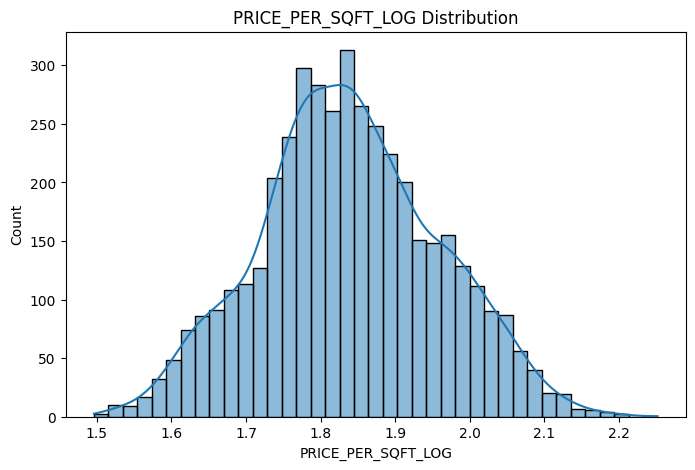

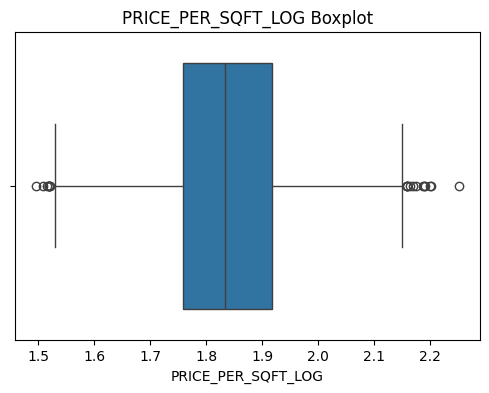

In [28]:
# Histogram and KDE plot for PRICE_PER_SQFT
plt.figure(figsize=(8, 5))
sns.histplot(df['PRICE_PER_SQFT_LOG'], kde=True)
plt.title('PRICE_PER_SQFT_LOG Distribution')
plt.show()
plt.figure(figsize=(6,4))
sns.boxplot(x=df["PRICE_PER_SQFT_LOG"])
plt.title('PRICE_PER_SQFT_LOG Boxplot')
plt.show()

In [29]:
feature_summary(df["PRICE_PER_SQFT_LOG"], "PRICE_PER_SQFT_LOG")


📦 Feature Summary: PRICE_PER_SQFT_LOG
Count: 4279
Mean: 1.83839
Median (Q2): 1.83374
Q1 (25th percentile): 1.75927
Q3 (75th percentile): 1.91773
IQR: 0.15846
Lower whisker: 1.52157
Upper whisker: 2.15542
Min: 1.49593
Max: 2.25168
Outliers detected: 21 (0.49077%)


#### Beds per sqft

In [30]:
df["BEDS_PER_SQFT"] = df["BEDS"] / df["PROPERTYSQFT"]

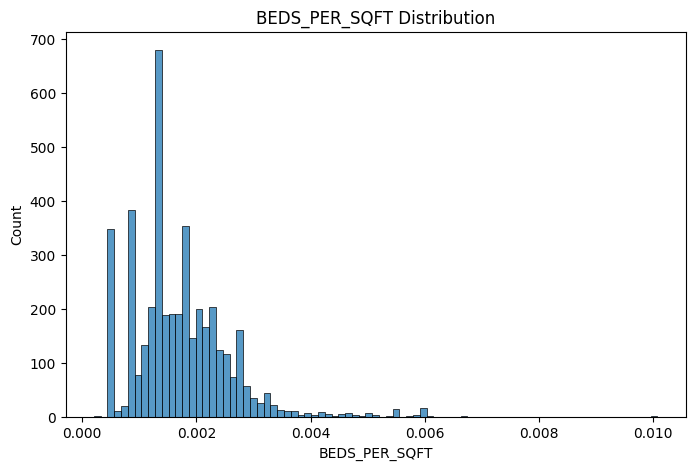

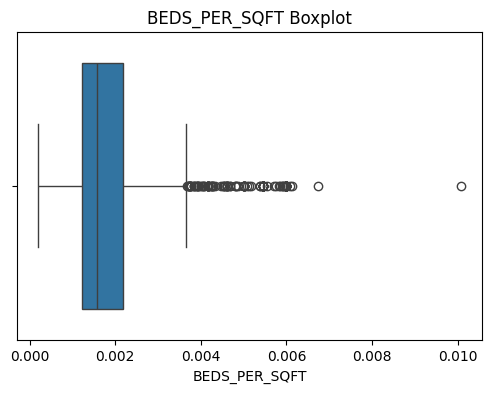

In [31]:
# Histogram and KDE plot for BEDS_PER_SQFT
plt.figure(figsize=(8, 5))
sns.histplot(df['BEDS_PER_SQFT'], kde=False)
plt.title('BEDS_PER_SQFT Distribution')
plt.show()
plt.figure(figsize=(6,4))
sns.boxplot(x=df["BEDS_PER_SQFT"])
plt.title('BEDS_PER_SQFT Boxplot')
plt.show()

In [32]:
feature_summary(df["BEDS_PER_SQFT"], "BEDS_PER_SQFT")


📦 Feature Summary: BEDS_PER_SQFT
Count: 4279
Mean: 0.00172
Median (Q2): 0.00157
Q1 (25th percentile): 0.00122
Q3 (75th percentile): 0.00219
IQR: 0.00097
Lower whisker: -0.00024
Upper whisker: 0.00365
Min: 0.00020
Max: 0.01008
Outliers detected: 106 (2.47721%)


#### Baths per sqft

In [33]:
df["BATH_PER_SQFT"] = df["BATH"] / df["PROPERTYSQFT"]

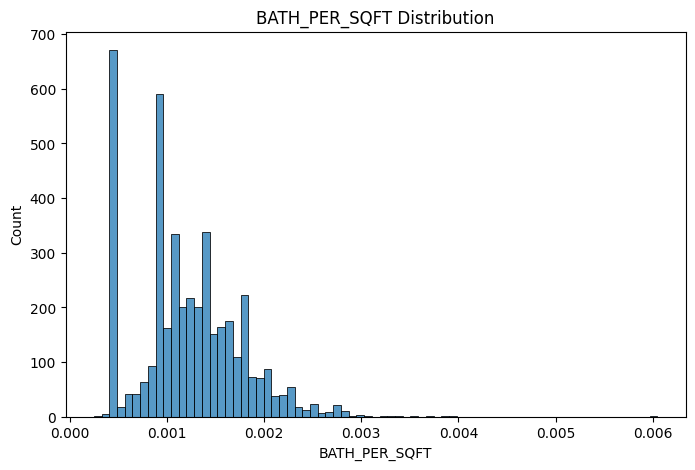

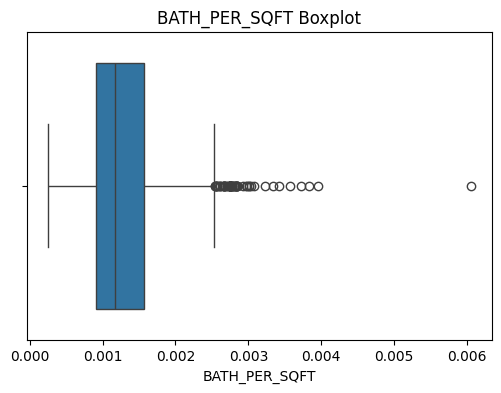

In [34]:
# Histogram and KDE plot for BATH_PER_SQFT
plt.figure(figsize=(8, 5))
sns.histplot(df['BATH_PER_SQFT'], kde=False)
plt.title('BATH_PER_SQFT Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df["BATH_PER_SQFT"])
plt.title('BATH_PER_SQFT Boxplot')
plt.show()



In [35]:
feature_summary(df["BATH_PER_SQFT"], "BATH_PER_SQFT")


📦 Feature Summary: BATH_PER_SQFT
Count: 4279
Mean: 0.00122
Median (Q2): 0.00118
Q1 (25th percentile): 0.00092
Q3 (75th percentile): 0.00156
IQR: 0.00065
Lower whisker: -0.00005
Upper whisker: 0.00253
Min: 0.00025
Max: 0.00605
Outliers detected: 65 (1.51905%)


#### RBF over SQRFT

Center point for RBF Kernel: [[7.68937111]]


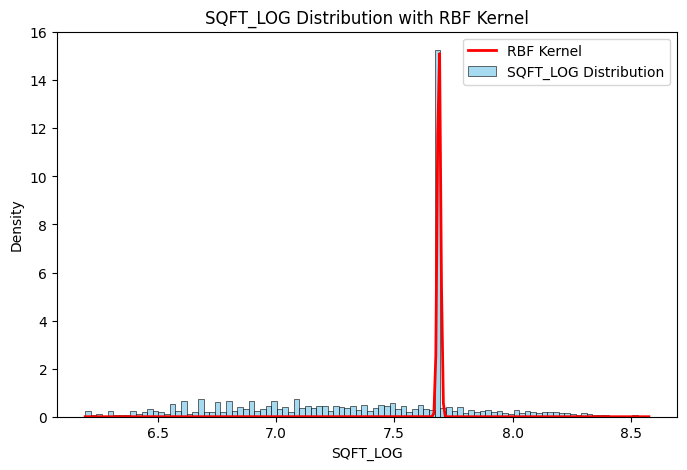

PRICE  BEDS  BATH  PROPERTYSQFT                    ADDRESS  \
0      315000     2   2.0   1400.000000       2 E 55th St Unit 803   
2      260000     4   2.0   2015.000000           620 Sinclair Ave   
5      690000     5   2.0   4004.000000                584 Park Pl   
6      899500     2   2.0   2184.207862     157 W 126th St Unit 1B   
8      265000     1   1.0    750.000000    875 Morrison Ave Apt 3M   
...       ...   ...   ...           ...                        ...   
4796   599000     1   1.0   2184.207862       222 E 80th St Apt 3A   
4797   245000     1   1.0   2184.207862        97-40 62 Dr Unit Lg   
4798  1275000     1   1.0   2184.207862  427 W 21st St Unit Garden   
4799   598125     2   1.0    655.000000   91-23 Corona Ave Unit 4G   
4800   349000     1   1.0    750.000000    460 Neptune Ave Apt 14O   

                        STATE ADMINISTRATIVE_AREA_LEVEL_2         LOCALITY  \
0          New York, NY 10022             New York County         New York   
2     Staten Island, NY 10312               United States         New York   
5          Brooklyn, NY 11238               United States         New York   
6          New York, NY 10027                    New York  New York County   
8             Bronx, NY 10473                Bronx County        The Bronx   
...                       ...                         ...              ...   
4796      Manhattan, NY 10075                    New York  New York County   
4797      Rego Park, NY 11374               United States         New York   
4798       New York, NY 10011               United States         New York   
4799       Elmhurst, NY 11373                    New York    Queens County   
4800       Brooklyn, NY 11224                    New York     Kings County   

          SUBLOCALITY       STREET_NAME   LATITUDE  LONGITUDE PRICE_CAT  \
0           Manhattan  East 55th Street  40.761255 -73.974483         1   
2     Richmond County     Staten Island  40.541805 -74.196109         1   
5        Kings County          Brooklyn  40.674363 -73.958725         2   
6            New York         Manhattan  40.809448 -73.946777         3   
8          East Bronx   Morrison Avenue  40.821586 -73.874089         1   
...               ...               ...        ...        ...       ...   
4796         New York         Manhattan  40.774350 -73.955879         2   
4797    Queens County            Queens  40.732538 -73.860152         1   
4798  New York County          New York  40.745882 -74.003398         4   
4799           Queens          Flushing  40.742770 -73.872752         2   
4800         Brooklyn      Coney Island  40.579147 -73.970949         1   

      PRICE_LOG  SQFT_LOG  PRICE_PER_SQFT_LOG  BEDS_PER_SQFT  BATH_PER_SQFT  \
0     12.660331  7.244942            1.747472       0.001429       0.001429   
2     12.468441  7.608871            1.638672       0.001985       0.000993   
5     13.444448  8.295299            1.620731       0.001249       0.000500   
6     13.709595  7.689466            1.782906       0.000916       0.000916   
8     12.487489  6.621406            1.885927       0.001333       0.001333   
...         ...       ...                 ...            ...            ...   
4796  13.303019  7.689466            1.730031       0.000458       0.000458   
4797  12.409018  7.689466            1.613768       0.000458       0.000458   
4798  14.058458  7.689466            1.828275       0.000458       0.000458   
4799  13.301557  6.486161            2.050760       0.003053       0.001527   
4800  12.762830  6.621406            1.927511       0.001333       0.001333   

      SQFT_LOG_RBF  
0     0.000000e+00  
2     7.182860e-29  
5     0.000000e+00  
6     9.999095e-01  
8     0.000000e+00  
...            ...  
4796  9.999095e-01  
4797  9.999095e-01  
4798  9.999095e-01  
4799  0.000000e+00  
4800  0.000000e+00  

[4279 rows x 19 columns]

In [36]:
from sklearn.metrics.pairwise import rbf_kernel

gamma_value = 10000.0

x_range = np.linspace(df["SQFT_LOG"].min(), df["SQFT_LOG"].max(), 300).reshape(-1, 1)

# Extract the center point from DF histogram
center_point = np.array([[df["SQFT_LOG"].median()]])
print(f"Center point for RBF Kernel: {center_point}")

# Compute RBF kernel values
rbf_curve = rbf_kernel(x_range, center_point, gamma=gamma_value).flatten()

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(df["SQFT_LOG"], kde=False, stat="density", bins=100, color="skyblue", label="SQFT_LOG Distribution")

# Escalar la curva para que se vea comparable al histograma
rbf_curve_scaled = rbf_curve * 16  # factor arbitrario para que se note en el gráfico
plt.plot(x_range, rbf_curve_scaled, color="red", linewidth=2, label="RBF Kernel")

plt.title("SQFT_LOG Distribution with RBF Kernel")
plt.xlabel("SQFT_LOG")
plt.ylabel("Density")
plt.legend()
plt.show()

df["SQFT_LOG_RBF"] = rbf_kernel(df[["SQFT_LOG"]], center_point, gamma=gamma_value).flatten()
df

#### Plotting

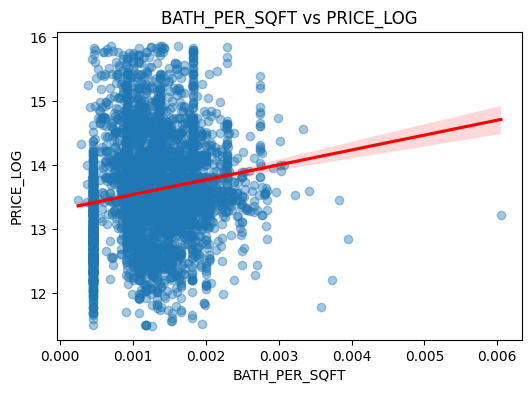

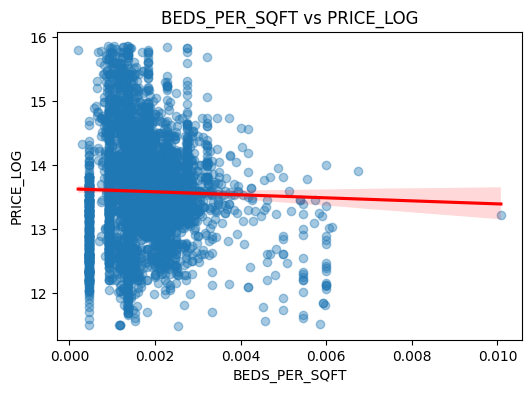

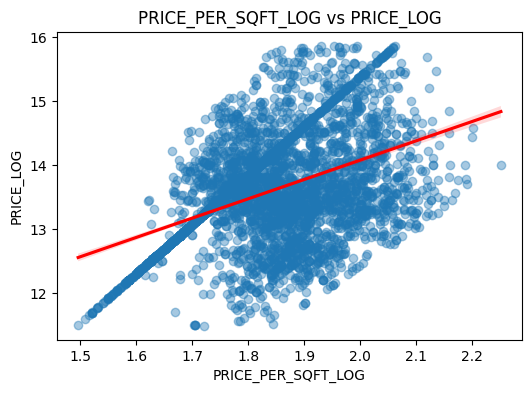

In [37]:

features = ["BATH_PER_SQFT", "BEDS_PER_SQFT", "PRICE_PER_SQFT_LOG"]

for f in features:
    plt.figure(figsize=(6,4))
    sns.regplot(x=df[f], y=df["PRICE_LOG"], scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
    plt.title(f"{f} vs PRICE_LOG")
    plt.show()

### Geospatial Features

Location-based features that capture the geographical context of the property.

Here we analyze geospatial features, such as the distance to points of interest like Manhattan, and also examine the location of the properties themselves.

Above all, we need to determine whether values like locality or sublocality make sense and provide relevant information.

Additionally, new information will be created using clustering with KMeans.

#### Distance to Manhattan

With this, we measure the straight-line distance to Manhattan, which is the nerve center of New York and where most attractions, services, and job opportunities are located.

Although this distance does not account for the actual distance by road, public transport, or walking, information that could be more relevant.

In [38]:
lat_c, lon_c = 40.7831, -73.9712

df["DIST_TO_MANHATTAN"] = np.sqrt(
    (df["LATITUDE"] - lat_c) ** 2 + (df["LONGITUDE"] - lon_c) ** 2
)

#### Distance to jfk airport

In [252]:
lat_c, lon_c = 40.6413, -73.7781
df["DIST_TO_JFK_AIRPORT"] = np.sqrt(
    (df["LATITUDE"] - lat_c) ** 2 + (df["LONGITUDE"] - lon_c) ** 2
)

#### Disntace to laguardia airport

In [253]:
lat_c, lon_c = 40.7769, -73.8740
df["DIST_TO_LAGUARDIA_AIRPORT"] = np.sqrt(
    (df["LATITUDE"] - lat_c) ** 2 + (df["LONGITUDE"] - lon_c) ** 2
)

#### Distance to times square

In [254]:
lat_c, lon_c = 40.7580, -73.9855
df["DIST_TO_TIMES_SQUARE"] = np.sqrt(
    (df["LATITUDE"] - lat_c) ** 2 + (df["LONGITUDE"] - lon_c) ** 2
)

#### Locality

In [39]:
# Define top 10 localities
top_n = 10
top_localities = df["LOCALITY"].value_counts().nlargest(top_n).index

# Create a new column grouping less frequent localities into "Other"
df["LOCALITY_GROUPED"] = df["LOCALITY"].apply(
    lambda x: x if x in top_localities else "Other"
)

print(df["LOCALITY_GROUPED"].value_counts())


LOCALITY_GROUPED
New York           2118
New York County     891
Queens County       550
Kings County        436
Bronx County        179
Richmond County      53
United States        34
Brooklyn              6
Queens                6
The Bronx             5
Other                 1
Name: count, dtype: int64


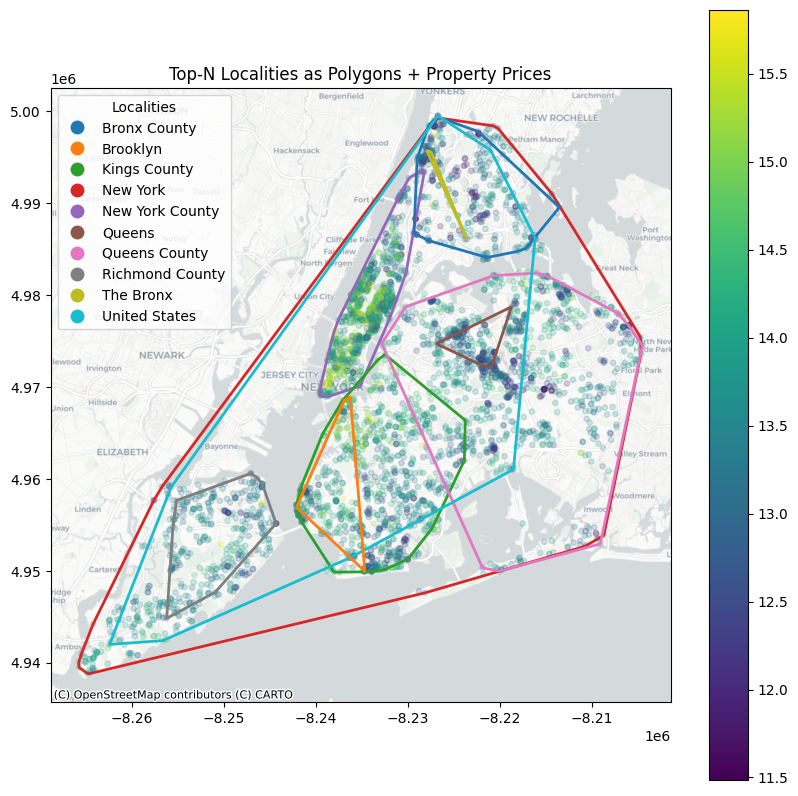

In [40]:
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Create polygons per locality_grouped
locality_polygons = []
for locality in gdf["LOCALITY_GROUPED"].unique():
    locality_points = gdf[gdf["LOCALITY_GROUPED"] == locality].geometry
    if len(locality_points) > 2:  # convex hull necesita >=3 puntos
        locality_polygons.append((locality, locality_points.union_all().convex_hull))

# GeoDataFrame with polygons
localities_gdf = gpd.GeoDataFrame(
    locality_polygons, columns=["LOCALITY_GROUPED", "geometry"], crs=gdf.crs
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# Houses colored by price
gdf.plot(
    ax          = ax,
    column      = "PRICE_LOG",
    cmap        = "viridis",
    markersize  = 15,
    alpha       = 0.2,
    legend      = True
)

# Locality polygons
localities_gdf.plot(
    ax          = ax,
    column      = "LOCALITY_GROUPED",
    categorical = True,
    cmap        = "tab10",      
    linewidth   = 2,
    edgecolor   = None,    
    facecolor   = "none", 
    legend      = True,
    legend_kwds = {"title": "Localities"}  
)

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Top-N Localities as Polygons + Property Prices")
plt.show()

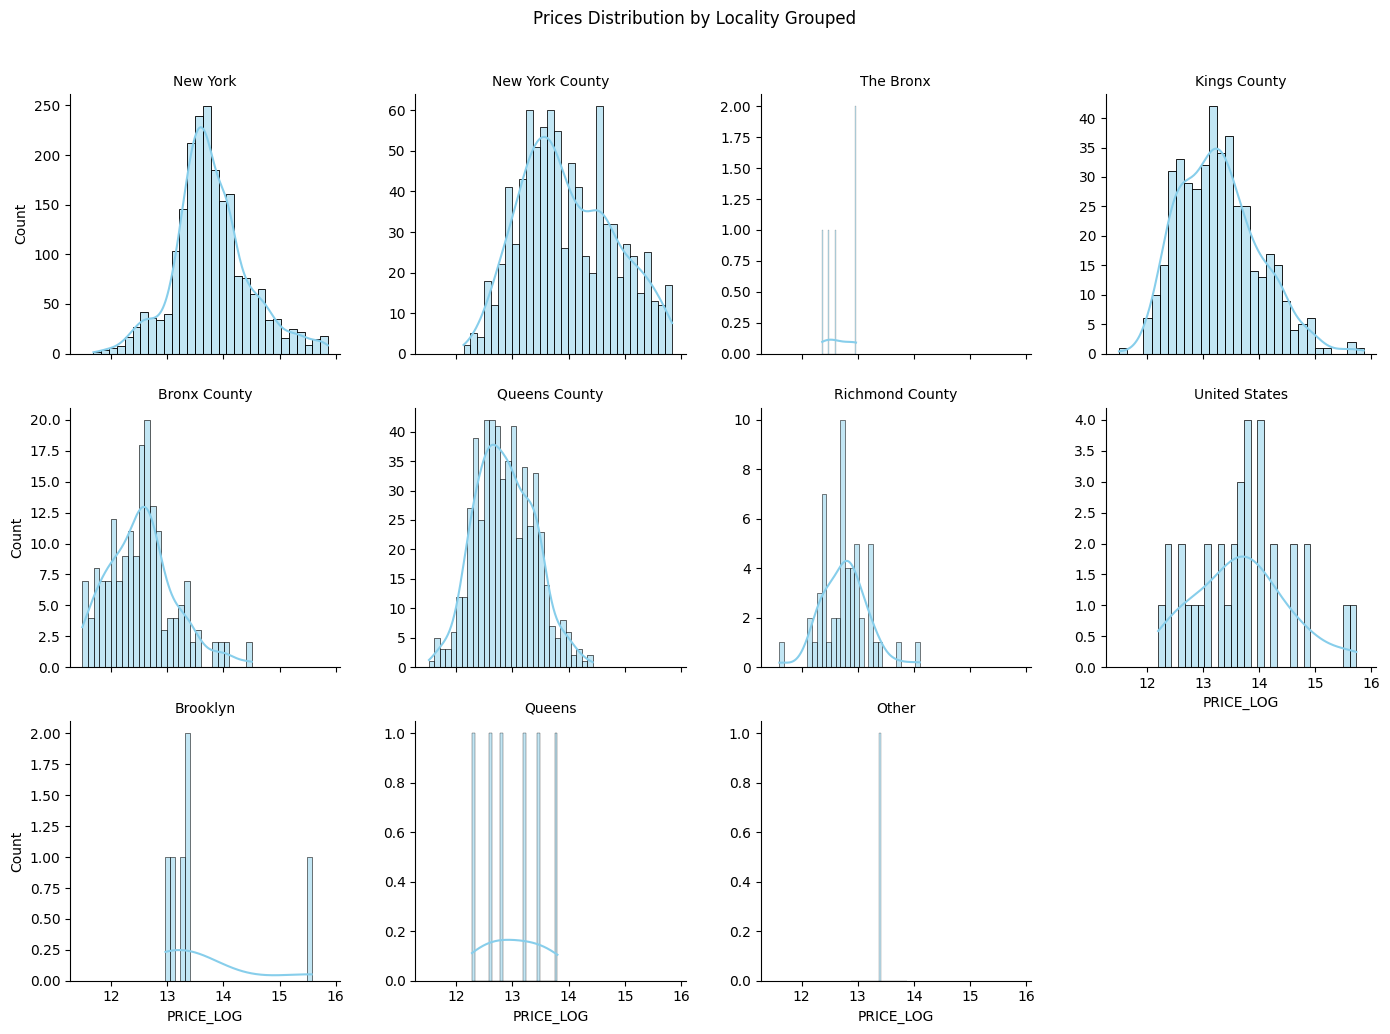

In [41]:
g = sns.FacetGrid(gdf, col="LOCALITY_GROUPED", col_wrap=4, height=3.5, sharex=True, sharey=False)
g.map_dataframe(sns.histplot, x="PRICE_LOG", bins=30, kde=True, color="skyblue")

g.set_axis_labels("PRICE_LOG", "Count")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Prices Distribution by Locality Grouped")
plt.show()

It can be seen that the data does not make much sense.

There are localities such as "United States" or "New York" that do not add value and also have very disparate prices or they cover very large areas.

This indicates that this feature is not relevant and does not add value.

#### Sublocality

In [42]:
# Define top 10 localities
top_n = 10
top_localities = df["SUBLOCALITY"].value_counts().nlargest(top_n).index

# Create a new column grouping less frequent localities into "Other"
df["SUBLOCALITY_GROUPED"] = df["SUBLOCALITY"].apply(
    lambda x: x if x in top_localities else "Other"
)

print(df["SUBLOCALITY_GROUPED"].value_counts())


SUBLOCALITY_GROUPED
New York           925
Queens County      634
Kings County       619
Queens             548
Richmond County    458
Brooklyn           436
Bronx County       257
The Bronx          181
New York County    131
Staten Island       53
Other               37
Name: count, dtype: int64


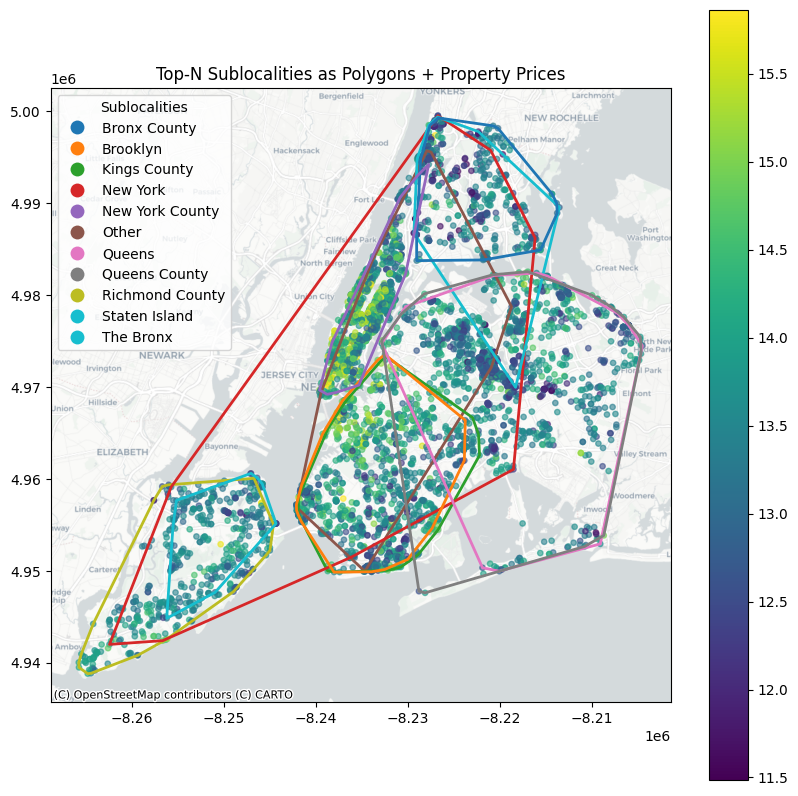

In [43]:
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Create polygons per SUBLOCALITY_GROUPED
locality_polygons = []
for locality in gdf["SUBLOCALITY_GROUPED"].unique():
    locality_points = gdf[gdf["SUBLOCALITY_GROUPED"] == locality].geometry
    if len(locality_points) > 2:  
        locality_polygons.append((locality, locality_points.union_all().convex_hull))

# GeoDataFrame with polygons
localities_gdf = gpd.GeoDataFrame(
    locality_polygons, columns=["SUBLOCALITY_GROUPED", "geometry"], crs=gdf.crs
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# Houses colored by price
gdf.plot(
    ax          = ax,
    column      = "PRICE_LOG",
    cmap        = "viridis",
    markersize  = 15,
    alpha       = 0.6,
    legend      = True
)

# Sublocality polygons
localities_gdf.plot(
    ax          = ax,
    column      = "SUBLOCALITY_GROUPED",
    categorical = True,
    cmap        = "tab10",      
    linewidth   = 2,
    facecolor   = "none", 
    legend      = True,      
    legend_kwds = {"title": "Sublocalities"} 
)

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Top-N Sublocalities as Polygons + Property Prices")
plt.show()

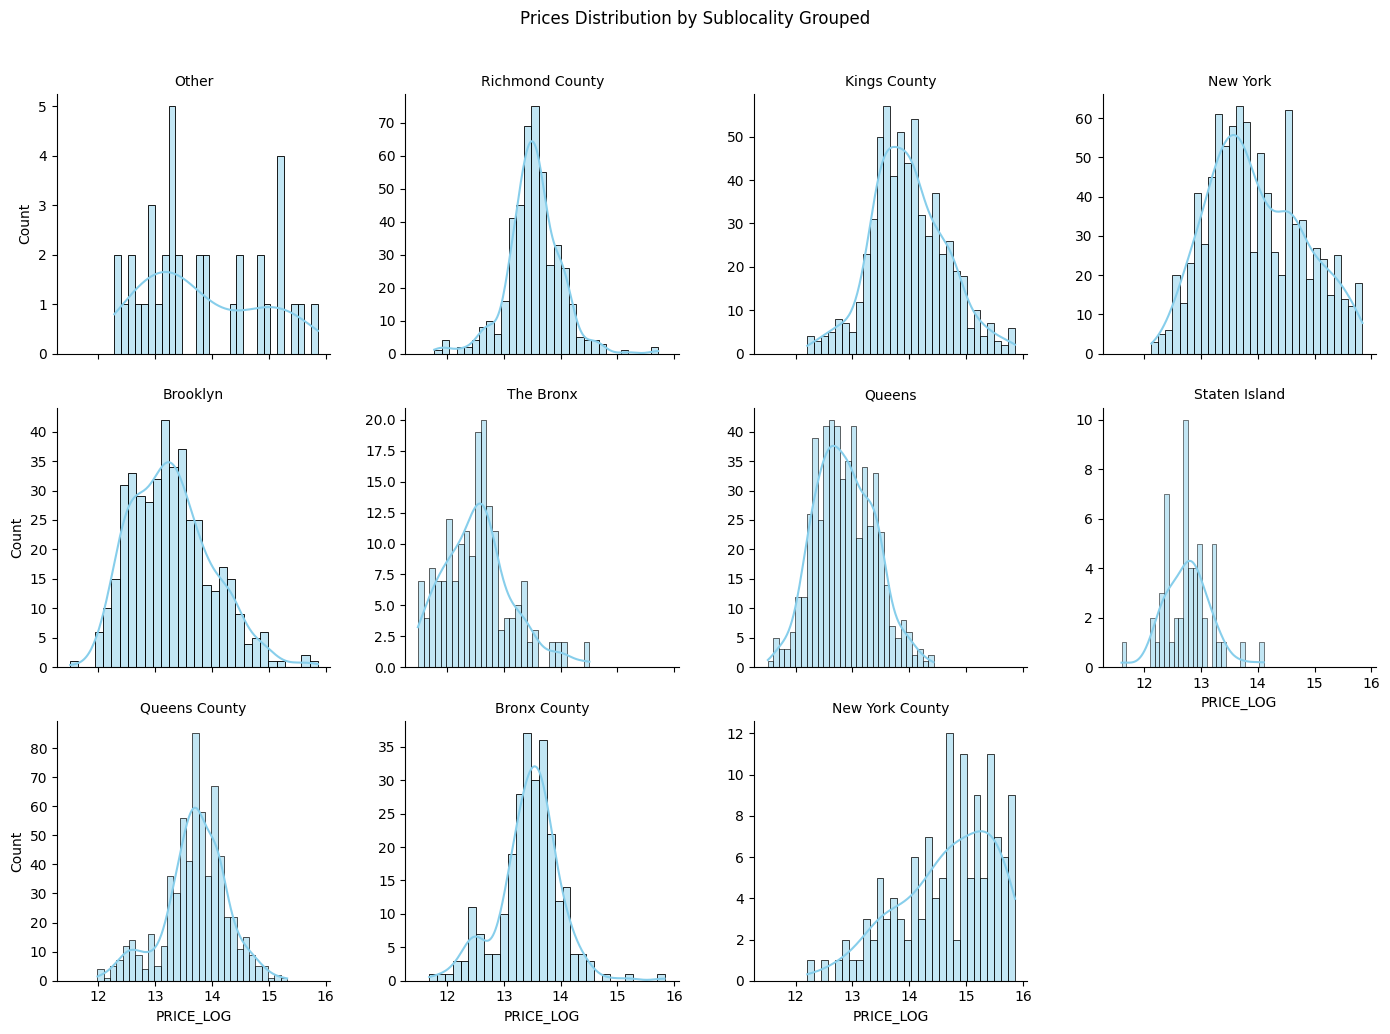

In [44]:
g = sns.FacetGrid(gdf, col="SUBLOCALITY_GROUPED", col_wrap=4, height=3.5, sharex=True, sharey=False)
g.map_dataframe(sns.histplot, x="PRICE_LOG", bins=30, kde=True, color="skyblue")

g.set_axis_labels("PRICE_LOG", "Count")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Prices Distribution by Sublocality Grouped")
plt.show()

In this case, the data makes more sense since sublocalities are smaller areas within localities.

Even so, there are sublocalities that do not add value, such as "New York," which covers a large area and includes many houses.



#### Cluster Similarity

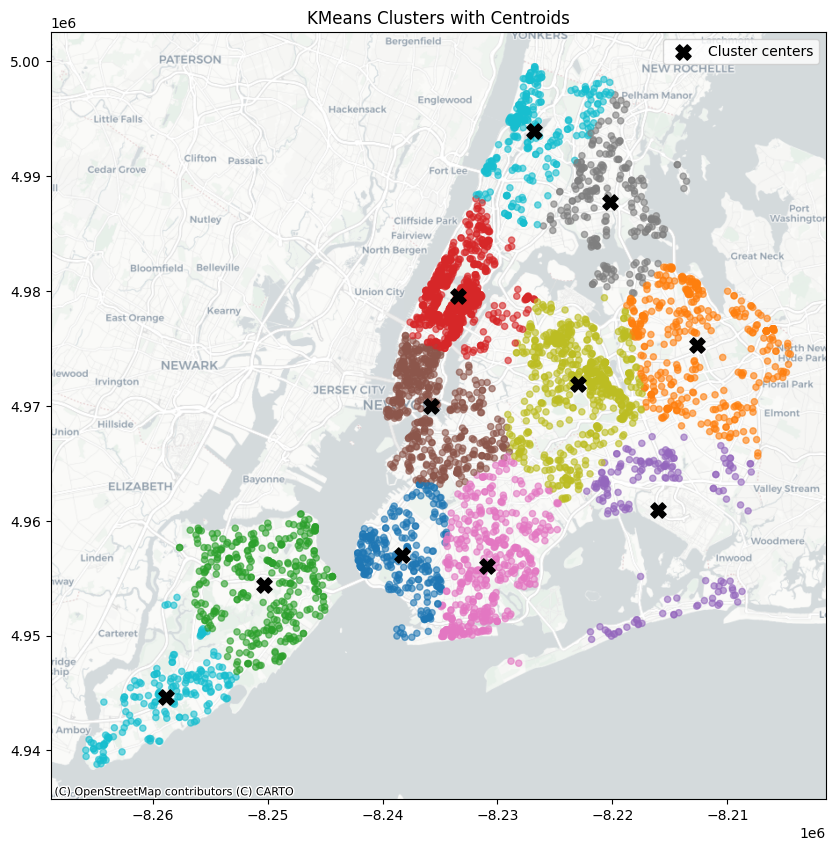

In [45]:
from sklearn.cluster import KMeans

# Create a feature in df that trains of latitude and longitude and creates 10 clusters
kmeans = KMeans(n_clusters=11, random_state=42)

kmeans.fit(df[["LATITUDE", "LONGITUDE"]])

labels = kmeans.labels_

df["ZONE_CLUSTER"] = labels

# --- Geometry for houses ---
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# --- Geometry for centroids ---
centroids = kmeans.cluster_centers_   # lat, lon en orden
centroid_points = [Point(xy[::-1]) for xy in centroids]  # invertir a (lon, lat)
centroids_gdf = gpd.GeoDataFrame(geometry=centroid_points, crs="EPSG:4326").to_crs(epsg=3857)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 10))

# Houses colored by cluster
gdf.plot(
    ax=ax,
    column="ZONE_CLUSTER",
    categorical=True,
    cmap="tab10",
    markersize=20,
    alpha=0.6,
    legend=True
)

# Centroids
centroids_gdf.plot(
    ax=ax,
    color="black",
    markersize=120,
    marker="X",
    label="Cluster centers"
)

#  Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("KMeans Clusters with Centroids")
plt.legend()
plt.show()


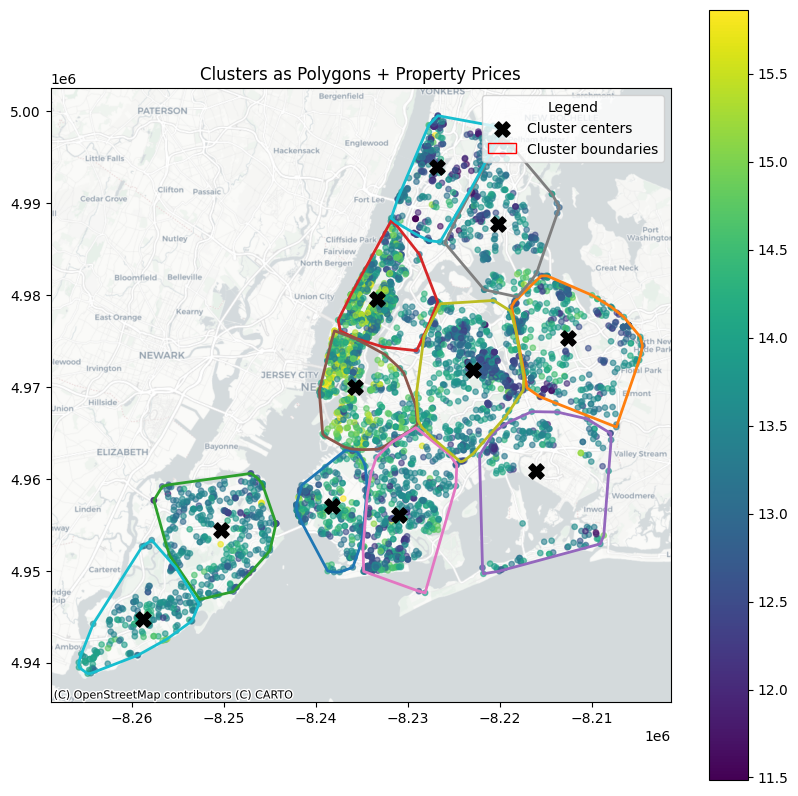

In [47]:
import matplotlib.patches as mpatches

cluster_polygons = []
for cluster_id in np.unique(gdf["ZONE_CLUSTER"]):
    cluster_points = gdf[gdf["ZONE_CLUSTER"] == cluster_id].geometry
    if len(cluster_points) > 2: 
        cluster_polygons.append((cluster_id, cluster_points.union_all().convex_hull))

clusters_gdf = gpd.GeoDataFrame(
    cluster_polygons, columns=["ZONE_CLUSTER", "geometry"], crs=gdf.crs
)

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    ax=ax,
    column="PRICE_LOG",
    cmap="viridis",
    markersize=15,
    alpha=0.6,
    legend=True
)

clusters_gdf.plot(
    ax=ax,
    column="ZONE_CLUSTER",
    categorical=True,
    cmap="tab10",
    facecolor="none",
    linewidth=2,
    legend=True,
    legend_kwds={"title": "Clusters"}
)

centroids_gdf.plot(
    ax=ax,
    color="black",
    markersize=120,
    marker="X",
    label="Cluster centers"
)

handles, labels = ax.get_legend_handles_labels()
cluster_patch = mpatches.Patch(edgecolor="red", facecolor="none", label="Cluster boundaries")
handles.append(cluster_patch)
ax.legend(handles=handles, title="Legend", loc="upper right")

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Clusters as Polygons + Property Prices")
plt.show()

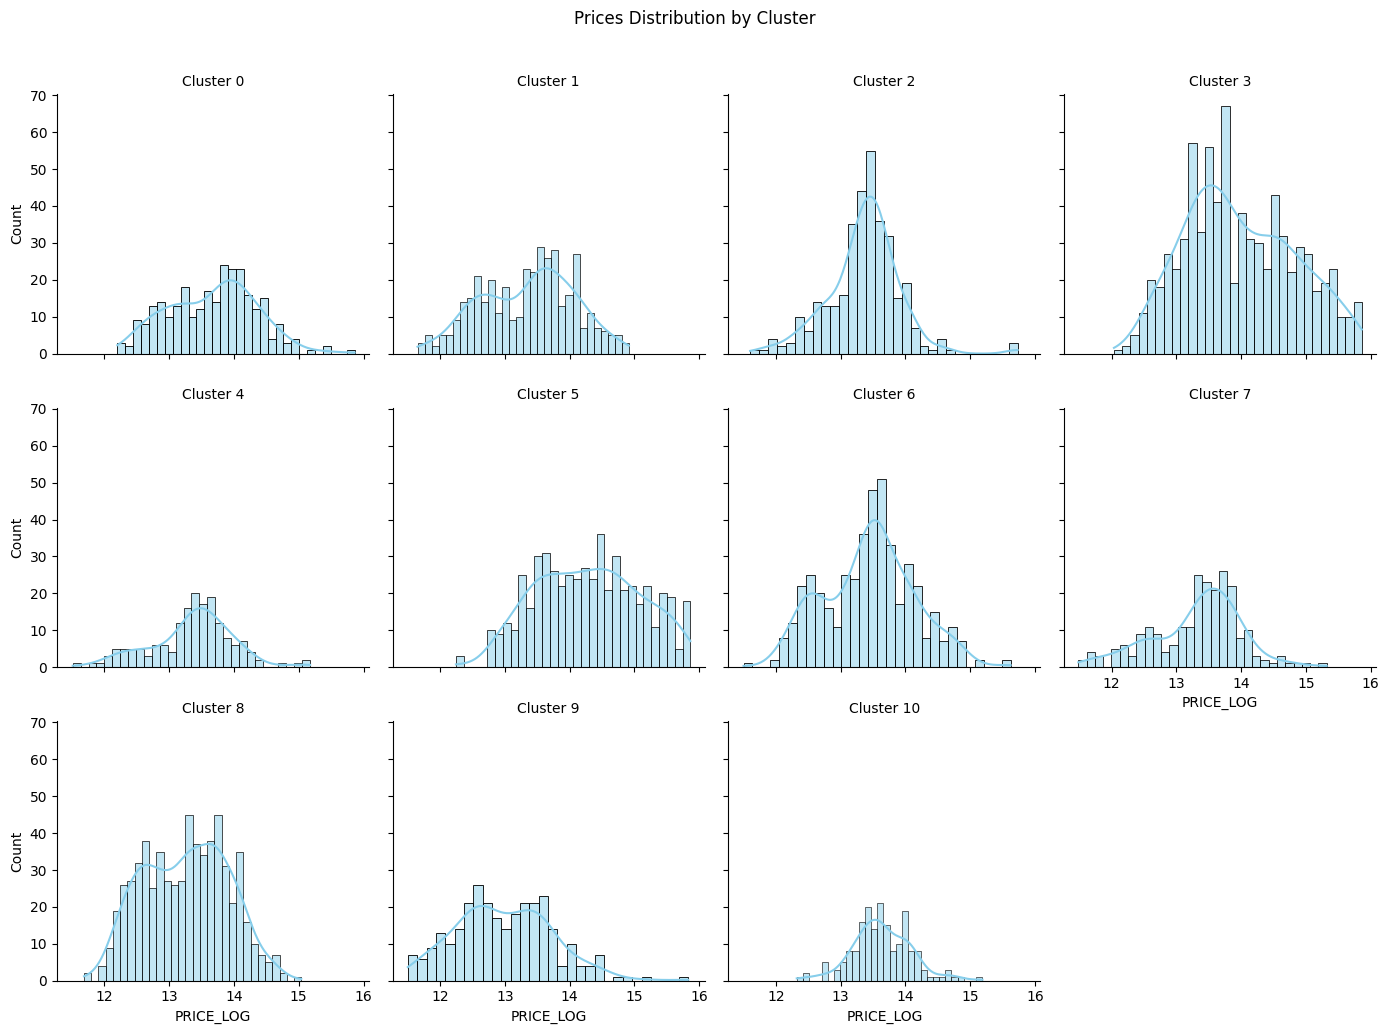

In [48]:
# Create a grid
g = sns.FacetGrid(gdf, col="ZONE_CLUSTER", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="PRICE_LOG", bins=30, kde=True, color="skyblue")

g.set_axis_labels("PRICE_LOG", "Count")
g.set_titles("Cluster {col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Prices Distribution by Cluster")
plt.show()

#### Sublocality

In [256]:
# Definir top-N zonas
top_n = 10
top_localities = df["SUBLOCALITY"].value_counts().nlargest(top_n).index

# Crear nueva columna
df["SUBLOCALITY_GROUPED"] = df["SUBLOCALITY"].apply(
    lambda x: x if x in top_localities else "Other"
)

print(df["SUBLOCALITY_GROUPED"].value_counts())


SUBLOCALITY_GROUPED
New York           956
Queens County      635
Kings County       619
Queens             554
Richmond County    460
Brooklyn           454
Bronx County       258
The Bronx          184
New York County    132
Staten Island       55
Other               37
Name: count, dtype: int64


### Interaction Features

Combinations of existing features that may capture more complex relationships.

In [ ]:
df["BEDS_TIMES_BATH"] = df["BEDS"] * df["BATH"]

df["SQFT_TIMES_DISTANCE"] = df["PROPERTYSQFT"] * df["DIST_TO_MANHATTAN"]

### Price log per location

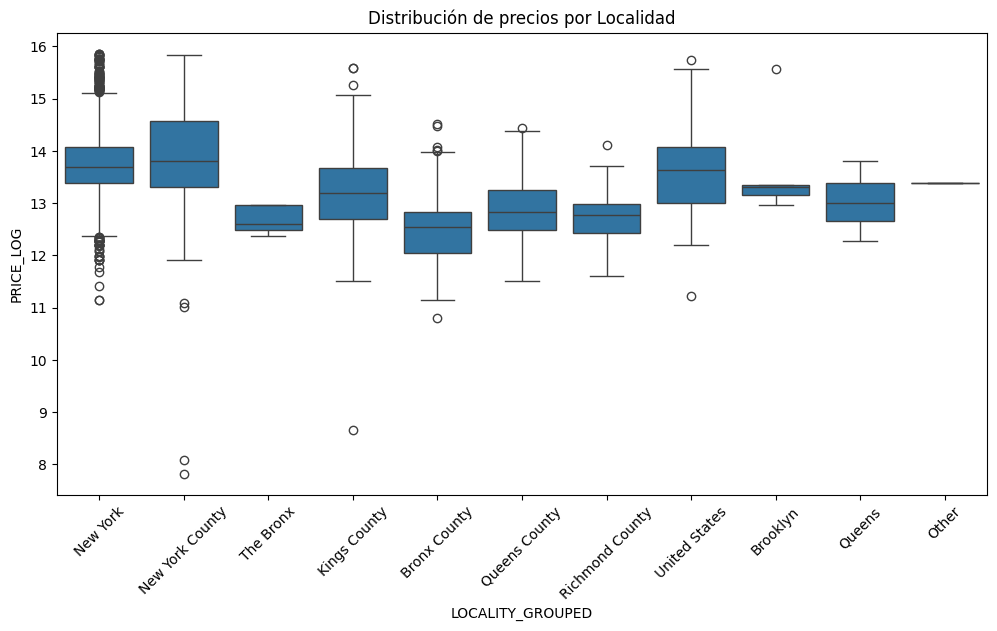

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="LOCALITY_GROUPED", y="PRICE_LOG", data=df)
plt.xticks(rotation=45)
plt.title("Distribución de precios por Localidad")
plt.show()


# Save cleaned dataset

In [ ]:
df.to_csv(r"./data/processed/NY-House-Dataset-Cleaned.csv", index=False)